See Bishop: 14.5.1 "Mixture of linear regression"

In [1]:
import numpy as np
import edward as ed
from edward.models import Normal, Bernoulli,InverseGamma, Dirichlet, ParamMixture, MultivariateNormalDiag
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy

ModuleNotFoundError: No module named 'edward'

In [12]:
def build_toy_dataset(N, D, K):
    pi = np.random.dirichlet([10.]*K)
    betas = [np.random.uniform(0.5,5,size=D) for _ in range(K)]
    #stds = [[0.1, 0.1], [0.1, 0.1]]
    x = np.zeros((N, D), dtype=np.float32)
    y = np.zeros(N, dtype=np.float32)
    k = np.zeros(N, dtype=np.int)
    for n in range(N):
        x[n,:] = np.random.multivariate_normal([0]*D, np.diag([1]*D))
        k[n] = np.argmax(np.random.multinomial(1, pi))
        y[n] = np.random.normal(loc=np.dot(x[n, :], betas[k[n]]), scale=0.5)
        #y[n] = np.random.binomial(n=1,
        #    p= 1/(1+np.exp(-np.dot(x[n, :], betas[k[n]]))) )

    return x,y,k,pi,betas

In [16]:
N = 500  # number of data points
D = 1  # dimensionality of data

X_train, y_train, k_train, pi, beta = build_toy_dataset(N, D, 2)

In [17]:
#from mpl_toolkits.mplot3d import Axes3D
#fig = plt.figure()
#ax = Axes3D(fig)
#plt.scatter(y_train, X_train, c=k_train, alpha=0.2)

In [24]:
pi
beta

beta

The generative process can be described as:

1. For each k = 1,2, ..., K:    
 - For each d = 1,2,...D:      
     - $\beta_d \sim Normal(0, 1)$     
 - $\sigma_k \sim InverseGamma(1, 1)$

2. For each observation n = 1,..., N:
 1. $pi_i \sim Dirichlet(1, 1,...,1)$  
 2. $z_i \sim Categorical(\pi_i)$
 3. $x_n \sim Normal(\mu^{z_i}, \sigma^{z_i})$  
    

In [5]:
K = 3
X = tf.placeholder(tf.float32, shape=[N,D])

In [6]:
beta = Normal(loc=tf.zeros(D), scale=1.0 * tf.ones(D), sample_shape=K)
#sigmasq = InverseGamma(tf.ones(D), tf.ones(D), sample_shape=K)

In [7]:
beta

<ed.RandomVariable 'Normal/' shape=(3, 2) dtype=float32>

In [8]:
#sigmasq

Now I'm stuck because the Mixture Model implementations in Edward don't allow to index and combine the beta_z and X_i

https://discourse.edwardlib.org/t/mixture-of-linear-regression-how/673

My conclusion is to switch to PyMC3

In [9]:
mixture_mu = tf.stack([
    1/(1+tf.exp(-ed.dot(X, beta[k,:])))
                       for k in range(K)], axis=0)
#mixture_sigmasq = tf.stack([[1.]*N for k in range(K)], axis=0)

In [10]:
mixture_mu

<tf.Tensor 'stack:0' shape=(3, 500) dtype=float32>

In [11]:
pi = [0.25,0.25,0.5]

In [12]:
x = ParamMixture(pi, # The mixture parameter 
                    {'probs':mixture_mu, 
                    # 'scale_diag': tf.sqrt(sigmasq)
                 }, # The parameters of the distribution
                 Bernoulli, # The distribution to sample from
                 #sample_shape = N
                ) # The number of samples

ValueError: Cannot reshape a tensor with 9 elements to shape [3] (3 elements) for 'ParamMixture/sample/Reshape' (op: 'Reshape') with input shapes: [3,3], [1] and with input tensors computed as partial shapes: input[1] = [3].

# PyMC

In [27]:
%matplotlib inline 
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import seaborn as sns
import theano
import theano.tensor as tt

In [31]:
N = 500  # number of data points
D = 1  # dimensionality of data

X_train, y_train, k_train, pi, beta = build_toy_dataset(N, D, K=2)

In [32]:
y_train[0:5]

array([-0.6524798, -1.0975041, -3.8637402, -0.0778416, -0.3504559],
      dtype=float32)

In [33]:
print(pi)
print(beta)

[0.2707946 0.7292054]
[array([0.75533873]), array([1.61839007])]


In [34]:
X_train = X_train.flatten()

In [35]:
ncls = 2
with pm.Model() as basic_model:
    w = pm.Dirichlet('w', np.ones(ncls))
    alpha = pm.Normal('alpha', mu=0, sd=1)
    beta = pm.Normal('beta', mu=0, sd=2, shape=ncls)
    sigma  = pm.Uniform('sigma', 0, 5)

    mu = tt.stack([alpha + beta[0]*X_train,
                   alpha + beta[1]*X_train], axis=1)

    y_obs = pm.NormalMixture('y_obs', w=w, mu=mu, tau=sigma, observed=y_train)

In [38]:
with basic_model:
    trace = pm.sample(100000, n_init=10000, tune=5000, )[1000:]
    #trace = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta, alpha, w]
Sampling 2 chains: 100%|██████████| 210000/210000 [08:17<00:00, 421.95draws/s]


In [39]:
pm.summary(trace).round(2)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,0.01,0.03,0.0,-0.05,0.06,180332.26,1.0
beta__0,0.80,0.08,0.0,0.63,0.96,136739.35,1.0
beta__1,1.63,0.04,0.0,1.55,1.71,138045.61,1.0
w__0,0.26,0.06,0.0,0.16,0.37,125177.13,1.0
w__1,0.74,0.06,0.0,0.63,0.84,125177.13,1.0
sigma,3.45,0.27,0.0,2.93,4.00,153265.32,1.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c1c121048>,
      dtype=object)

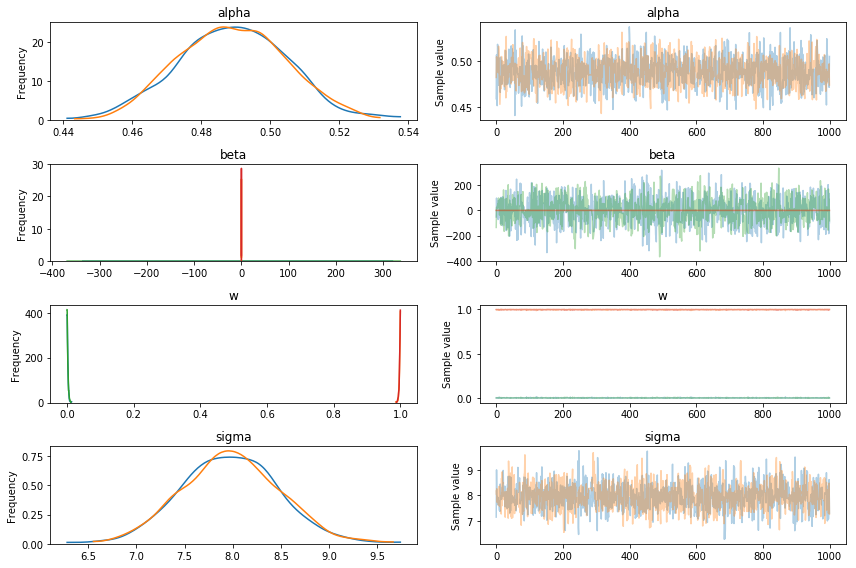

In [14]:
pm.traceplot(trace)